In [99]:
import tensorflow as tf
# import tf_keras as keras
# from tf_keras import layers, models
# import tensorflow.keras as keras
import keras
from keras import layers, models
import matplotlib.pyplot as plt
# import cv2
import numpy as np

In [100]:
import tensorflow_datasets as tfds

(_, _, test_ds), dataset_info = tfds.load(
    name='eurosat',
    split=['train[:60%]', 'train[60%:80%]','train[80%:]'],
    with_info=True,
    as_supervised=True,
    batch_size=32,
)

In [101]:
batch_size = 32
img_height = 64
img_width = 64
img_shape = (img_height,img_width)
num_classes = 10

In [102]:
from base_model import make_base_model

base_model = make_base_model(img_height, img_width, num_classes)
base_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
base_model.load_weights('eurosat/weights/base_model.weights.h5')

/home/klia/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [103]:
base_model.evaluate(test_ds)

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7256 - loss: 2.9673


[2.9498696327209473, 0.7137036919593811]

In [104]:
from att_model import make_att_model

att_model = make_att_model(img_height, img_width, 10)
att_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
att_model.load_weights('eurosat/weights/att_model.weights.h5')

/home/klia/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [105]:
att_model.evaluate(test_ds)

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8685 - loss: 0.6441


[0.6747411489486694, 0.8614814877510071]

### Use gradcam to see what the models "pay attention" to:

In [106]:
# Code for Grad-CAM, modified from tensorflow.org

import keras
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, img_width, img_height, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        inputs=model.inputs, 
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(image, heatmap, cam_path="cam.jpg", alpha=0.4, save=False):
    import matplotlib as mpl
    # Load the original image
    img = keras.utils.load_img(image) if isinstance(image, str) else image
    img = keras.utils.img_to_array(img)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    print(jet_heatmap.shape)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    if save:
        superimposed_img.save(cam_path)

    # Display Grad CAM
    from IPython.display import Image, display
    return superimposed_img

In [107]:
img = test_ds.unbatch().take(1).get_single_element()[0]
img.shape

TensorShape([64, 64, 3])

In [108]:
img = test_ds.unbatch().take(1).get_single_element()[0]
img = np.expand_dims(img, axis=0)
# image_raw = unbatched.get_single_element()
# img = get_img_array(image_raw, img_shape)
base_model.layers[-1].activation = None
print(base_model.predict(img))
att_model.layers[-1].activation=None
print(att_model.predict(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
[[  5.5576015  25.74142     5.1771054  14.835442   -9.662662   43.106937
  -26.024946  -11.923952   22.138721   19.372883 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
[[-17.126339  -18.530493  -11.165258   -4.524884  -13.949113    7.3039994
  -10.77248    -4.190617   -1.6543658 -10.438511 ]]


(64, 64, 3)


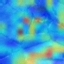

In [109]:
hm_base = make_gradcam_heatmap(img,base_model,'conv_3_2')
save_and_display_gradcam(img[0], hm_base)

(64, 64, 3)


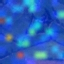

In [113]:
hm_att = make_gradcam_heatmap(img,att_model,'conv_3_2')
save_and_display_gradcam(img[0], hm_att)

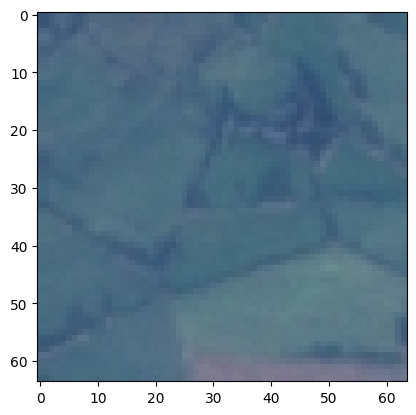

In [114]:
plt.imshow(img[0])

Also, we can try visualizing the weights of the linear attention layer:

In [125]:
vis_attn_model = keras.models.Model(
    inputs=att_model.inputs,
    outputs = att_model.get_layer('Attention_3').output
)

g, c = vis_attn_model.predict(img)
c_softmax = np.exp(c)/np.exp(c).sum()
c.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


(1, 121, 1)

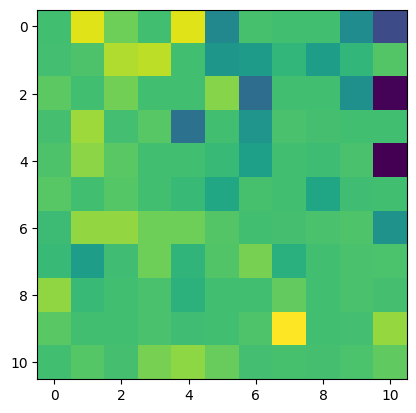

In [126]:
shape = int(np.sqrt(c.shape[-2]))
c_rs = tf.reshape(c, (1,shape, shape))
c_reduced = tf.reduce_mean(c_rs, axis=0)
plt.imshow(c_reduced)

In [127]:
c_reduced_norm = (c_reduced-np.min(c_reduced))/(np.max(c_reduced)-np.min(c_reduced))

<Axes: >

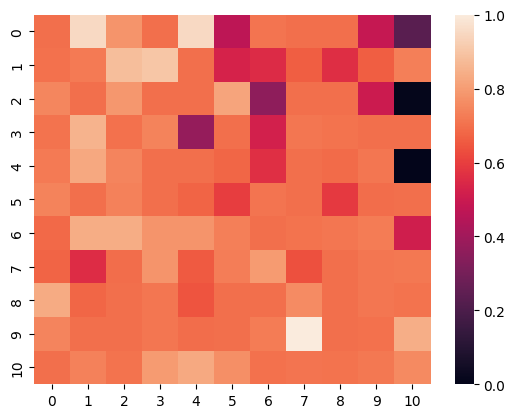

In [128]:
from seaborn import heatmap
heatmap(c_reduced_norm)

(64, 64, 3)


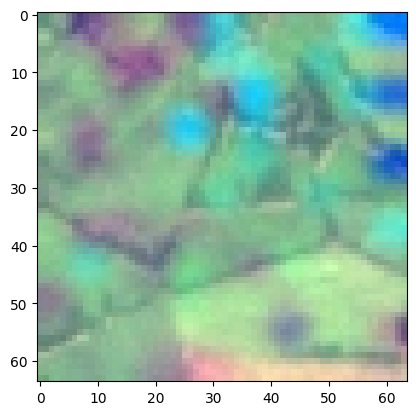

In [131]:
import matplotlib as mpl
heatmap = np.uint8(255 * c_reduced_norm)
    # Use jet colormap to colorize heatmap
jet = mpl.colormaps["jet"]
    # Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
from IPython.display import Image, display
hmimg = save_and_display_gradcam(img[0], c_reduced_norm,alpha=0.2, cam_path=f'', save=False)
plt.imshow(hmimg)